### Transformada de Hough

Para esta parte se ha leído y adaptado el capítulo dedicado a esta sección del libro titulado:

_Hands-On Image Processing with Python_ de Sandipan Dey

En el procesamiento de imágenes , la transformada de Hough es una técnica para detectar líneas rectas en una imagen. Posteriormente, esta técnica evolucionó para detectar más formas más allá de rectas, cómo pueden ser los cìrculos y las elipses, y pasó a denominarse: Transformada de Hough Generalizada.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage import data
from skimage.transform import (hough_line, hough_line_peaks, hough_circle, hough_circle_peaks)
from skimage.draw import circle_perimeter
from skimage.color import gray2rgb
from matplotlib import cm

In [23]:
path_img = "CASIA_v1" + os.sep + "001_1_1.bmp"
img = data.imread(path_img)
# plt.imshow(img);

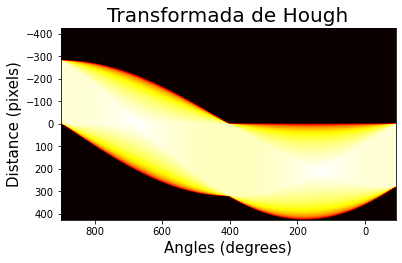

In [4]:
# Classic straight-line Hough transform
h, theta, d = hough_line(img)

plt.imshow(np.log(1 + h),
           extent=[10*np.rad2deg(theta[-1]),
           np.rad2deg(theta[0]), d[-1], d[0]],
           cmap=cm.hot, aspect=1/1.5);


plt.title('Transformada de Hough', size=20)
plt.xlabel('Angles (degrees)', size=15)
plt.ylabel('Distance (pixels)', size=15);

In [17]:
def draw_pupil(img, cx, cy, radio):
    '''
    A partir de los centros y el radio detectados dibuja la pupila sobre la imagen que se le
    pasa como parámetro.
    '''
    image = gray2rgb(img) # convertimos a color
    for center_y, center_x, radius in zip(cy, cx, radio):
        circy, circx = circle_perimeter(center_y, center_x, radius)
        image[circy, circx] = (0, 255, 0) # green
    return image

Aunque apliquemos Canny, nunca llegará a detectar el borde límbico ya que las pestañas impiden ver la circunferencia del iris, es por ello que para detectar el borde pupilar no ha tenido problemas.

In [18]:
sigma = 0.7 # valor bajo de sigma proporciona un umbral más ajustado, mientras que uno alto, proporcionará uno más amplio
median = np.median(img) 

# apply automatic Canny edge detection using the computed median
lower = int(max(0, (1.0 - sigma) * median)) # lower of double threshold
upper = int(min(255, (1.0 + sigma) * median))  # upper of double threshold
auto_canny = cv2.Canny(img, lower, upper)

Al aplicar el Hough de círculos sobre la muestra a la que se ha aplicado previamente Canny se  obtienen los centros y el radio de la pupila únicamente porque es el único "círculo limpio" que encuentra en la muestra.

Se usa el método `hough_circle_peaks()` pero no resulta útil ya que para usarlo se debe conocer a priori el número de círculos que deberá detectarse en la imagen, aunque para localizar el iris nos valdría(ya que siempre serán 2 círculos los que deberán detectarse), se prefiere buscar otro método que sea más general y detecte los círculos automáticamente, aunque para ello se necesita primero los bordes detectados correctamente.

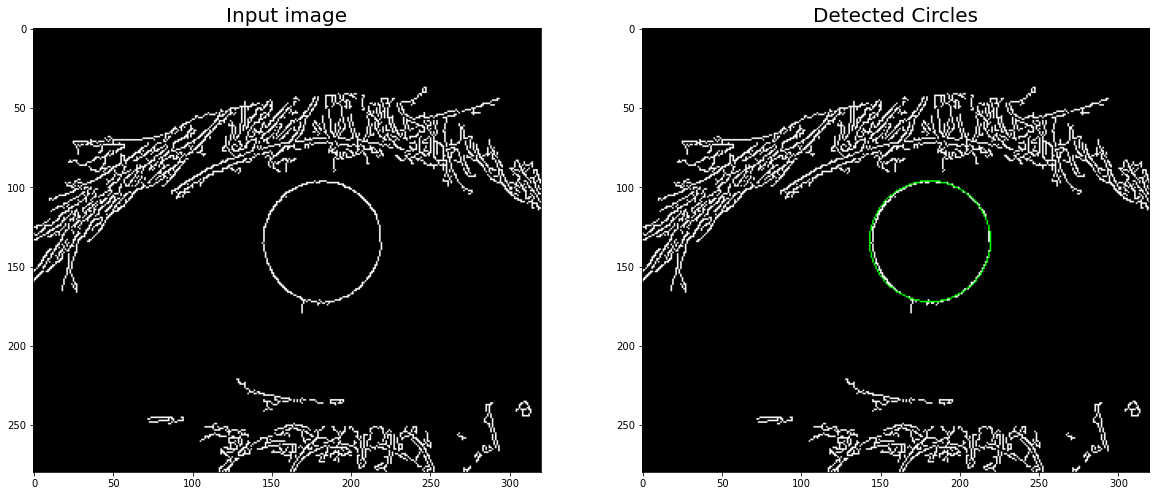

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(20, 20))
ax = axes.ravel()

hough_radii = np.arange(20, 60, 2) # ajustar manualmente para que empiece desde un rango que incluya a la pupila
hough_res = hough_circle(auto_canny, hough_radii)

# Seleccionamos el círculo más prominente, en este caso, sólo hay uno
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1) # total_num_peaks -> nro de círculos
pupil = draw_pupil(auto_canny, cx, cy, radii) # pupila detectada


# print eyes
ax[0].imshow(auto_canny, cmap=cm.gray)
ax[0].set_title('Input image', size=20)
ax[1].imshow(pupil)
ax[1].set_title('Detected Circles', size=20);

Una vez obtenida los centros, se pueden dibujar sobre la muestra original, pero no nos es de gran ayuda ya que el borde límbico sigue sin ser detectado.

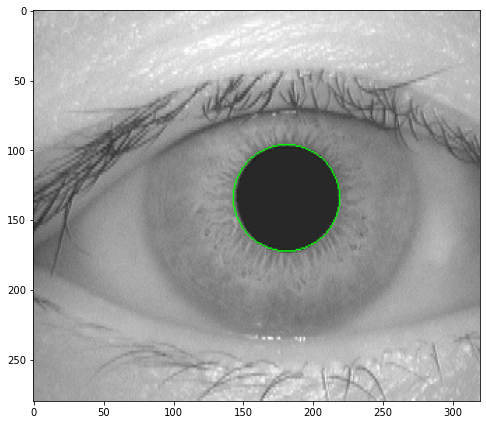

In [20]:
pupil = draw_pupil(img, cx, cy, radii) # pupila detectada
plt.figure(figsize = (8,8))
plt.imshow(pupil);